### 1.1 EDA

##### data 불러오기

In [1]:
import pandas as pd
retail_df = pd.read_excel(io='online_retail_II.xlsx')

In [2]:
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Customer ID 정수형으로 변환
# 비회원이라 NaN으로 저장된 객체에 대해서는 -1로

retail_sp = retail_df.copy()
retail_sp['Customer ID'] = retail_sp['Customer ID'].fillna(-1).astype(int)
retail_sp.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


##### 시간에 따른 구매 트렌드 분석

- 국가별 구매 추이 시각화

In [4]:
retail_ts = retail_sp[['InvoiceDate', 'Quantity', 'Price', 'Country']]
retail_ts.loc[:, 'sales_amount'] = retail_ts['Quantity'] * retail_ts['Price']

import datetime as dt
retail_ts.loc[:, 'InvoiceDate'] = retail_ts['InvoiceDate'].dt.date

retail_ts.head()

C:\Users\ShinJiyoon\AppData\Local\Temp\ipykernel_34368\2823580761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_ts.loc[:, 'sales_amount'] = retail_ts['Quantity'] * retail_ts['Price']


,InvoiceDate,Quantity,Price,Country,sales_amount
0,2009-12-01,12,6.95,United Kingdom,83.4
1,2009-12-01,12,6.75,United Kingdom,81.0
2,2009-12-01,12,6.75,United Kingdom,81.0
3,2009-12-01,48,2.10,United Kingdom,100.8
4,2009-12-01,24,1.25,United Kingdom,30.0


In [5]:
quantity_by_date = retail_ts.groupby(['InvoiceDate', 'Country'])['Quantity'].sum().reset_index()
sales_amount_by_date = retail_ts.groupby(['InvoiceDate', 'Country'])['sales_amount'].sum().reset_index()

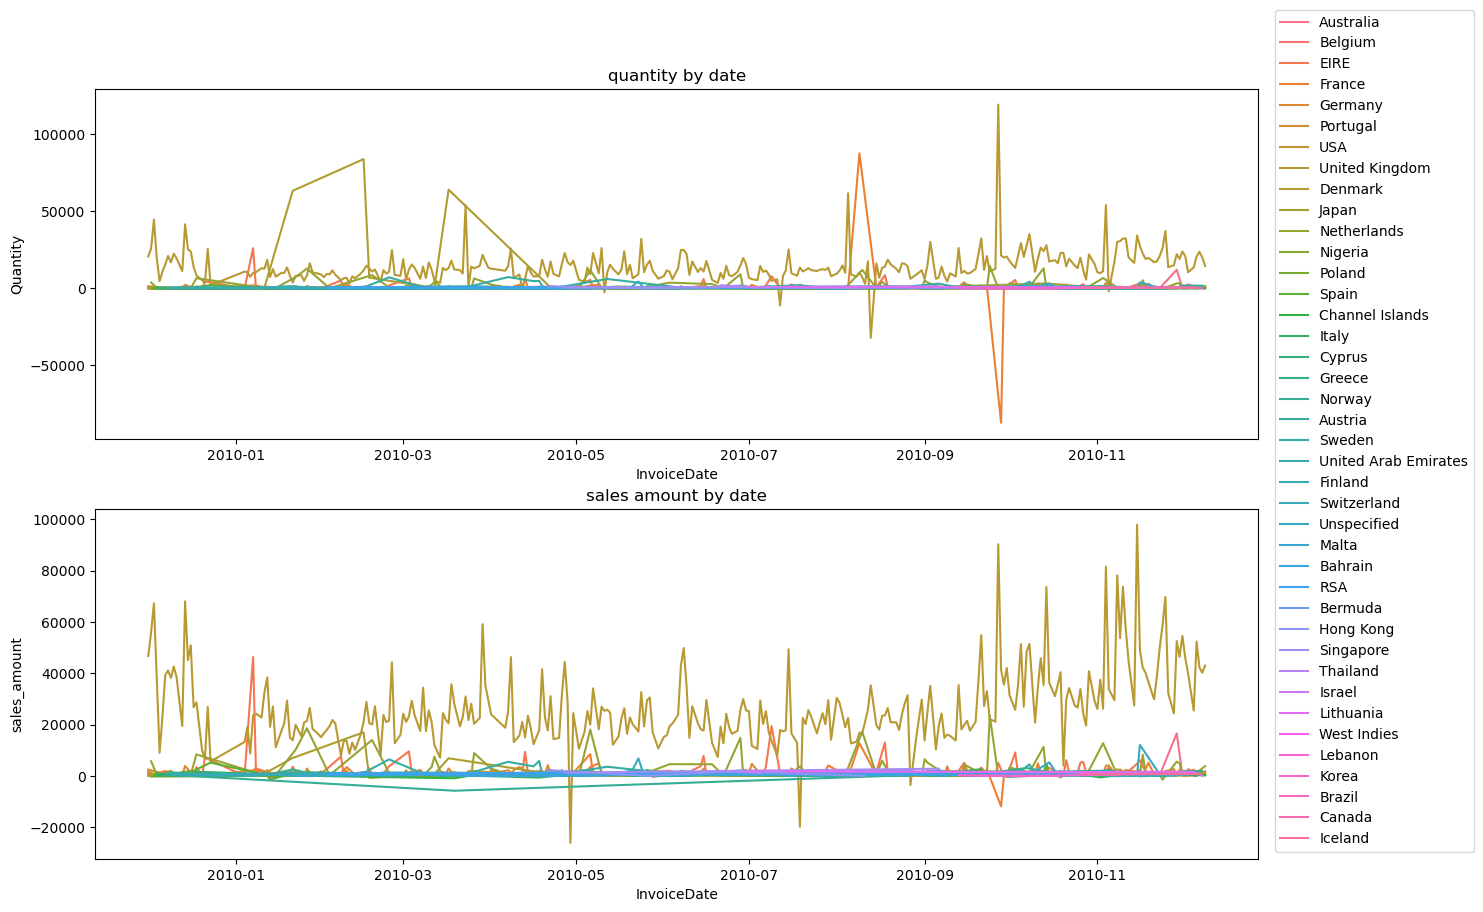

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=quantity_by_date, x='InvoiceDate', y='Quantity', hue='Country', ax=axes[0])
axes[0].set_title('quantity by date')
sns.lineplot(data=sales_amount_by_date, x='InvoiceDate', y='sales_amount', hue='Country', ax=axes[1])
axes[1].set_title('sales amount by date')

axes[0].legend().remove()
axes[1].legend(bbox_to_anchor=(1.1, 0), loc='lower center')

plt.show()

- 전반적으로 판매량이 증가하고 있음: 유의미하다고 볼 수 있는지는 모르겠음
- **United Kingdom이 다른 국가에 비해 더 활발하게 구매활동을 했음**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


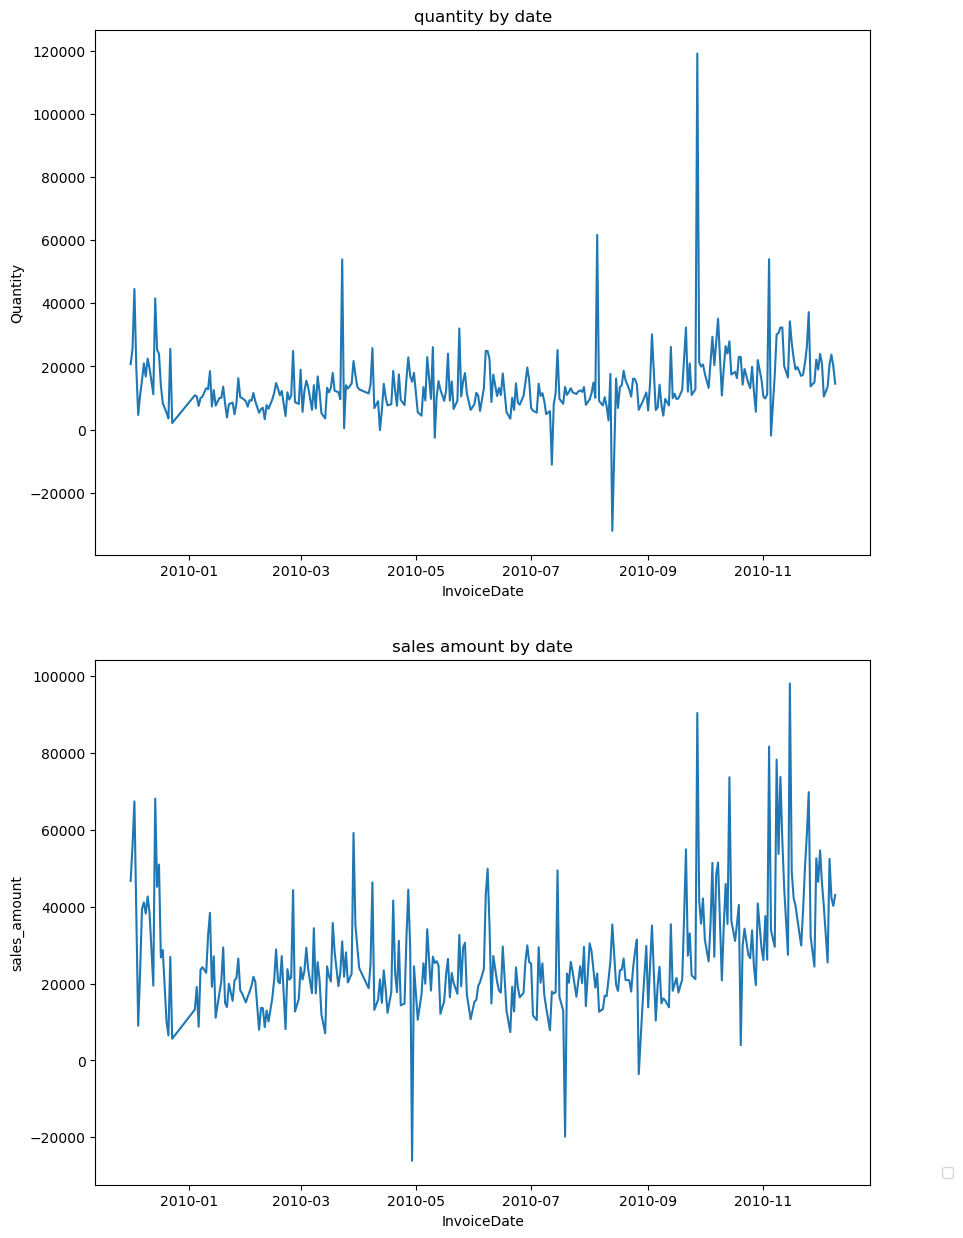

In [7]:
quantity_by_date_UK = quantity_by_date[quantity_by_date['Country']=='United Kingdom']
sales_amount_by_date_UK = sales_amount_by_date[sales_amount_by_date['Country']=='United Kingdom']


fig, axes = plt.subplots(2, 1, figsize=(10, 15))
sns.lineplot(data=quantity_by_date_UK, x='InvoiceDate', y='Quantity', ax=axes[0])
axes[0].set_title('quantity by date')
sns.lineplot(data=sales_amount_by_date_UK, x='InvoiceDate', y='sales_amount', ax=axes[1])
axes[1].set_title('sales amount by date')

axes[0].legend().remove()
axes[1].legend(bbox_to_anchor=(1.1, 0), loc='lower center')

plt.show()

- 오르내림의 폭은 다양하지만, 그 **주기는 일정**해보임: 다음과 같은 요인을 예상해볼 수 있음
    - 계절성: 휴가 시즌이나 연말연시에는 소비자들의 구매량이 증가하거나 감소할 수 있음
    - 경제적 요인: 경제 침체기에는 소비자들의 소비 패턴이 변할 수 있음
    - 마케팅 활동: 회사의 주기적인 이벤트나 프로모션에 따라 특정 주기에 구매량이 증가할 수 있음

--------
* 회원/비회원 구매 추이 시각화

In [8]:
retail_mem = retail_sp[['InvoiceDate', 'Quantity', 'Price', 'Customer ID']]

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    retail_mem['sales_amount'] = retail_mem['Quantity'] * retail_mem['Price']
    retail_mem['InvoiceDate'] = retail_mem['InvoiceDate'].dt.date
    retail_mem['membership'] = retail_mem['Customer ID'].apply(lambda x: 'membership' if x>= 0 else 'non-membership')

m_quantity_by_date = retail_mem.groupby(['InvoiceDate', 'membership'])['Quantity'].sum().reset_index()
m_sales_amount_by_date = retail_mem.groupby(['InvoiceDate', 'membership'])['sales_amount'].sum().reset_index()

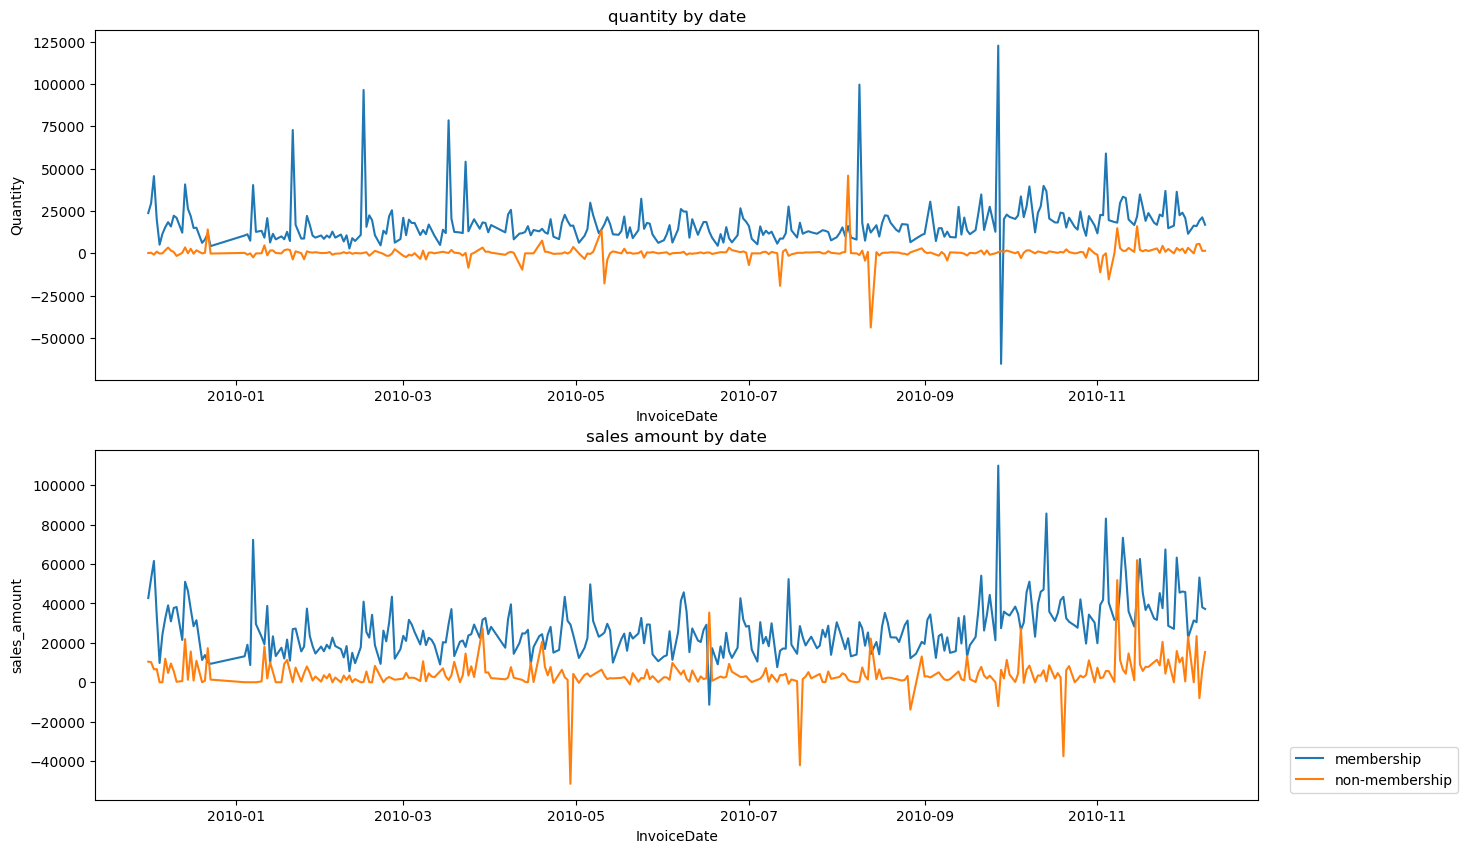

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=m_quantity_by_date, x='InvoiceDate', y='Quantity', hue='membership', ax=axes[0])
axes[0].set_title('quantity by date')
sns.lineplot(data=m_sales_amount_by_date, x='InvoiceDate', y='sales_amount', hue='membership', ax=axes[1])
axes[1].set_title('sales amount by date')

axes[0].legend().remove()
axes[1].legend(bbox_to_anchor=(1.1, 0), loc='lower center')

plt.show()

In [10]:
retail_mem['membership'].value_counts()

membership
membership        417534
non-membership    107927
Name: count, dtype: int64

* 회원의 표본 수가 더 많음을 감안하더라도, 비회원에 비해 회원의 구매활동이 더 활발함을 알 수 있음

### 1.2 data preprocessing

> 구매활동이 활발했던 United Kingdom 회원 고객들을 대상으로, 고객 유형을 군집화하고 각 고객군의 주된 주문 제품은 무엇인지 확인하고자 함
* 따라서 구매국가가 United Kingdom인 회원 고객만 추출, 취소 및 반품은 제외

In [11]:
# 구매국가가 영국인 경우만
retail_sp = retail_sp[retail_sp['Country']=='United Kingdom']

# 회원인 고객만
retail_sp = retail_sp[retail_sp['Customer ID']>0]

# 취소반품 고객 제외
retail_sp = retail_sp[retail_sp['Price']>0]
retail_sp = retail_sp[retail_sp['Quantity']>0]

retail_sp

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


### 1.3 RFM feature 만들기

##### M feature 만들기
monetary = sales amount = quantity * price

In [12]:
retail_sp['sales_amount'] = retail_sp['Quantity'] * retail_sp['Price']

##### RFM 지표 만들기

In [13]:
rfm = {
    'InvoiceDate': 'max',
    'Invoice': 'count',
    'sales_amount': 'sum'
}

cust_df = retail_sp.groupby('Customer ID').agg(rfm)
cust_df

,InvoiceDate,Invoice,sales_amount
Customer ID,,,
12346,2010-06-28 13:53:00,33,372.86
12608,2010-10-31 10:49:00,16,415.79
12745,2010-08-10 10:14:00,22,723.85
12746,2010-06-17 10:41:00,17,254.55
12747,2010-12-05 15:38:00,154,5080.53
...,...,...,...
18283,2010-11-22 15:30:00,230,641.77
18284,2010-10-04 11:33:00,28,461.68
18285,2010-02-17 10:24:00,12,427.00


##### R feature 만들기
recency = invoicedate - 현재

In [14]:
max(retail_sp['InvoiceDate'])

Timestamp('2010-12-09 20:01:00')

2010년 12월 9일 데이터까지 있으므로 recency를 현재 날짜를 2011년 1월 1일으로 가정

In [15]:
cust_df['Recency'] = cust_df['InvoiceDate'] - dt.datetime(2011, 1, 1)

# days 뿐 아니라 시간도 포함된 상태이므로,
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)

cust_rfm = cust_df[['Invoice', 'sales_amount', 'Recency']]
cust_rfm.rename(columns={'Invoice': 'Frequency', 'sales_amount': 'Monetary'}, inplace=True)

cust_rfm


C:\Users\ShinJiyoon\AppData\Local\Temp\ipykernel_34368\3322715200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_rfm.rename(columns={'Invoice': 'Frequency', 'sales_amount': 'Monetary'}, inplace=True)


,Frequency,Monetary,Recency
Customer ID,,,
12346,33,372.86,-186
12608,16,415.79,-61
12745,22,723.85,-143
12746,17,254.55,-197
12747,154,5080.53,-26
...,...,...,...
18283,230,641.77,-39
18284,28,461.68,-88
18285,12,427.00,-317


### 1.4 RFM feature 활용해 clustering

##### RFM feature

In [16]:
cust_rfm

,Frequency,Monetary,Recency
Customer ID,,,
12346,33,372.86,-186
12608,16,415.79,-61
12745,22,723.85,-143
12746,17,254.55,-197
12747,154,5080.53,-26
...,...,...,...
18283,230,641.77,-39
18284,28,461.68,-88
18285,12,427.00,-317


##### data scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

mns = MinMaxScaler()
scaled = mns.fit_transform(cust_rfm)
rfm_scaled = pd.DataFrame(data=scaled, columns=cust_rfm.columns)
rfm_scaled

,Frequency,Monetary,Recency
0,0.006347,0.001059,0.560322
1,0.002975,0.001182,0.895442
2,0.004165,0.002065,0.675603
3,0.003173,0.000721,0.530831
4,0.030345,0.014542,0.989276
...,...,...,...
3964,0.045418,0.001830,0.954424
3965,0.005355,0.001314,0.823056
3966,0.002182,0.001214,0.209115
3967,0.013090,0.003705,0.702413


##### K-means clustering modeling

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=111)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=5, random_state=111)

##### evaluating K

elbow method

<Axes: >

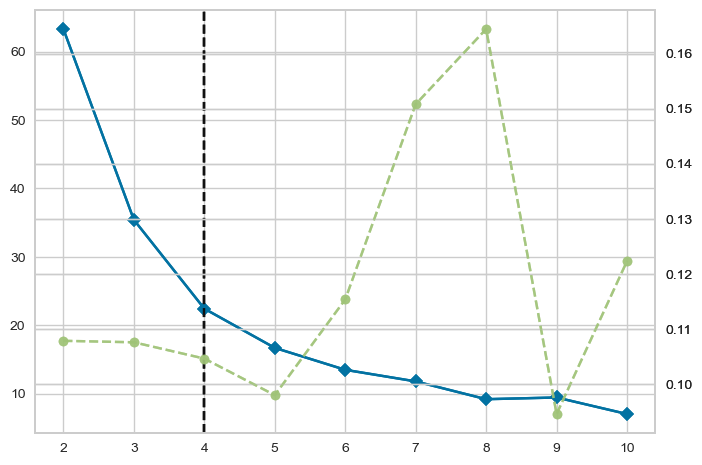

In [19]:
from yellowbrick.cluster import KElbowVisualizer
elbow = KElbowVisualizer(kmeans)
elbow.fit(rfm_scaled)
elbow.draw()

k=4 지점에서 급격히 감소하고 있음
* 위 그래프는 cluster 내 데이터간 거리의 제곱합이므로, k가 커질수록 감소하는 형태를 띰
* 너무 큰 k는 너무 많은 cluster를 생성해 과적화되는 결과를 낳을 수 있으므로, 그래프에서 값이 급격하게 감소하고 있는 elbow 지점을 k로 정하는 것이 바람직함

silhouette coefficient

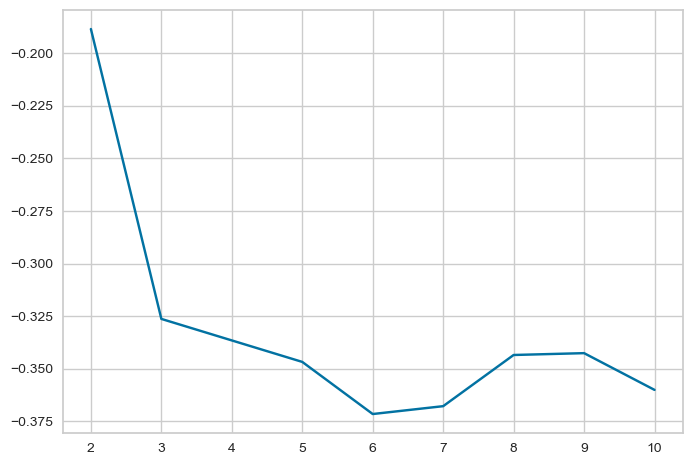

In [20]:
sil_coef = []

from sklearn.metrics import silhouette_score
for i in range(2, 11):
    kmeans_sil = KMeans(n_clusters=i, random_state=111)
    kmeans_sil.fit(rfm_scaled)
    score = silhouette_score(cust_rfm, kmeans_sil.labels_)
    sil_coef.append(score)

plt.plot(range(2, 11), sil_coef)
plt.xticks(range(2, 11))
plt.show()

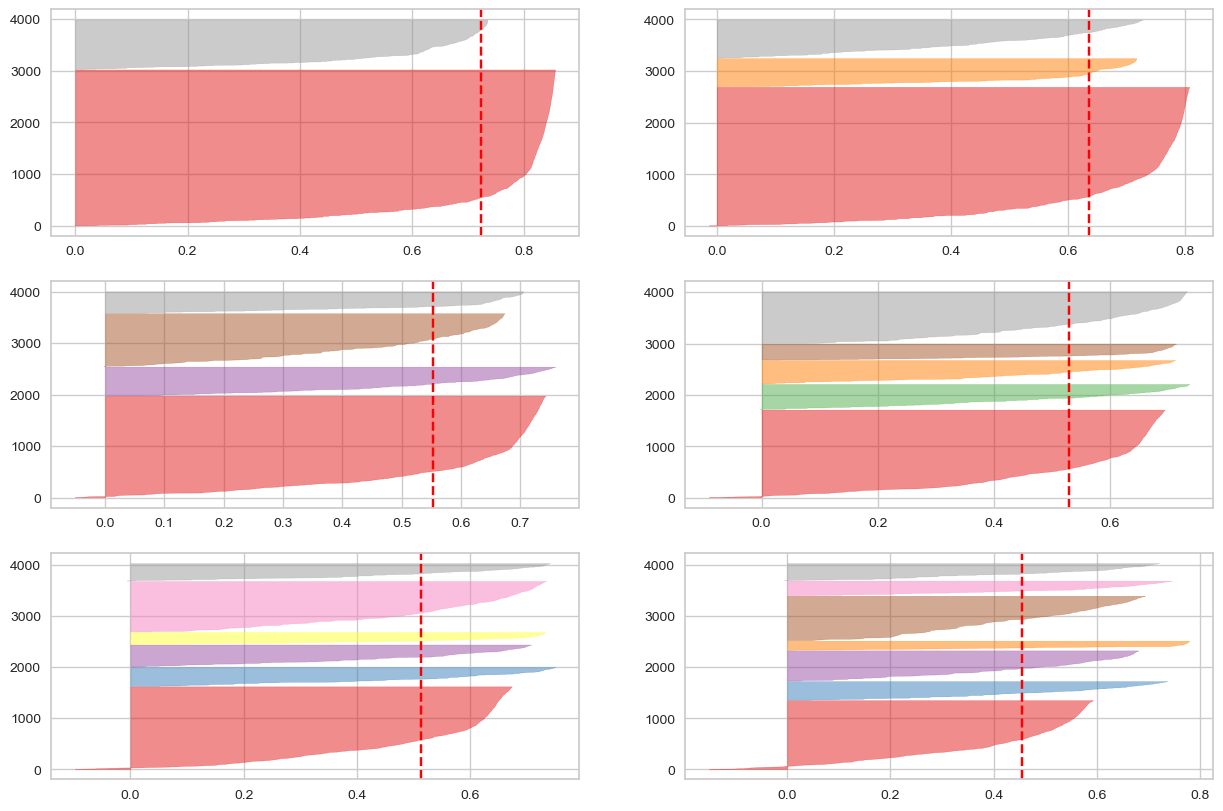

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

from yellowbrick.cluster import SilhouetteVisualizer
for i in range(2, 8):
    kmeans_sil = KMeans(n_clusters=i, random_state=111)
    q, mod = divmod(i, 2)
    visual = SilhouetteVisualizer(kmeans_sil, ax=ax[q-1][mod])
    visual.fit(rfm_scaled)

k=4가 가장 적절해보임!

### 1.5 K-means clustering 결과와 RFM feature 병합

In [22]:
kmeans = KMeans(n_clusters=4, random_state=111)
kmeans

KMeans(n_clusters=4, random_state=111)

In [23]:
cust_rfm['cluster_kn'] = kmeans.fit_predict(cust_rfm)
cust_rfm

,Frequency,Monetary,Recency,cluster_kn
Customer ID,,,,
12346,33,372.86,-186,2
12608,16,415.79,-61,2
12745,22,723.85,-143,2
12746,17,254.55,-197,2
12747,154,5080.53,-26,2
...,...,...,...,...
18283,230,641.77,-39,2
18284,28,461.68,-88,2
18285,12,427.00,-317,2


In [24]:
import numpy as np
retail_sp['cluster_kn'] = np.nan

for ID, cluster in zip(cust_rfm.index, cust_rfm['cluster_kn']):
    retail_sp.loc[retail_sp['Customer ID']==ID, 'cluster_kn'] = cluster
    
retail_sp['cluster_kn'] = retail_sp['cluster_kn'].astype(int)
retail_sp

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,sales_amount,cluster_kn
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,2
...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90,2
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75,2
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75,2
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50,2


### 1.6 군집별 분석

In [25]:
from scipy import stats

cluster_agg = {'Customer ID': 'count',
               'Quantity': ['sum', 'mean', 'std'],
               'Price': ['mean', 'std'],
               'sales_amount': ['mean', 'std'],
               'InvoiceDate': 'max'
               }

cluster_stats = retail_sp.groupby('cluster_kn').agg(cluster_agg)

cluster_stats.columns = ['count', 'quantity_sum', 'quantity_mean', 'quantity_std', 'price_mean', 'price_std', 'sales_amount_mean', 'sales_amount_std', 'date_max']

cluster_stats

,count,quantity_sum,quantity_mean,quantity_std,price_mean,price_std,sales_amount_mean,sales_amount_std,date_max
cluster_kn,,,,,,,,,
0,65174,1141367,17.512612,126.321751,3.484790,60.715887,26.947552,96.520671,2010-12-09 17:34:00
1,627,124216,198.111643,173.177097,3.491930,4.728798,556.880941,580.590511,2010-12-09 13:44:00
2,292976,2518157,8.595097,23.608045,3.062106,9.271130,14.775725,26.721595,2010-12-09 20:01:00
3,12152,664833,54.709760,184.399098,3.315643,81.535672,80.676355,250.669445,2010-12-09 14:15:00


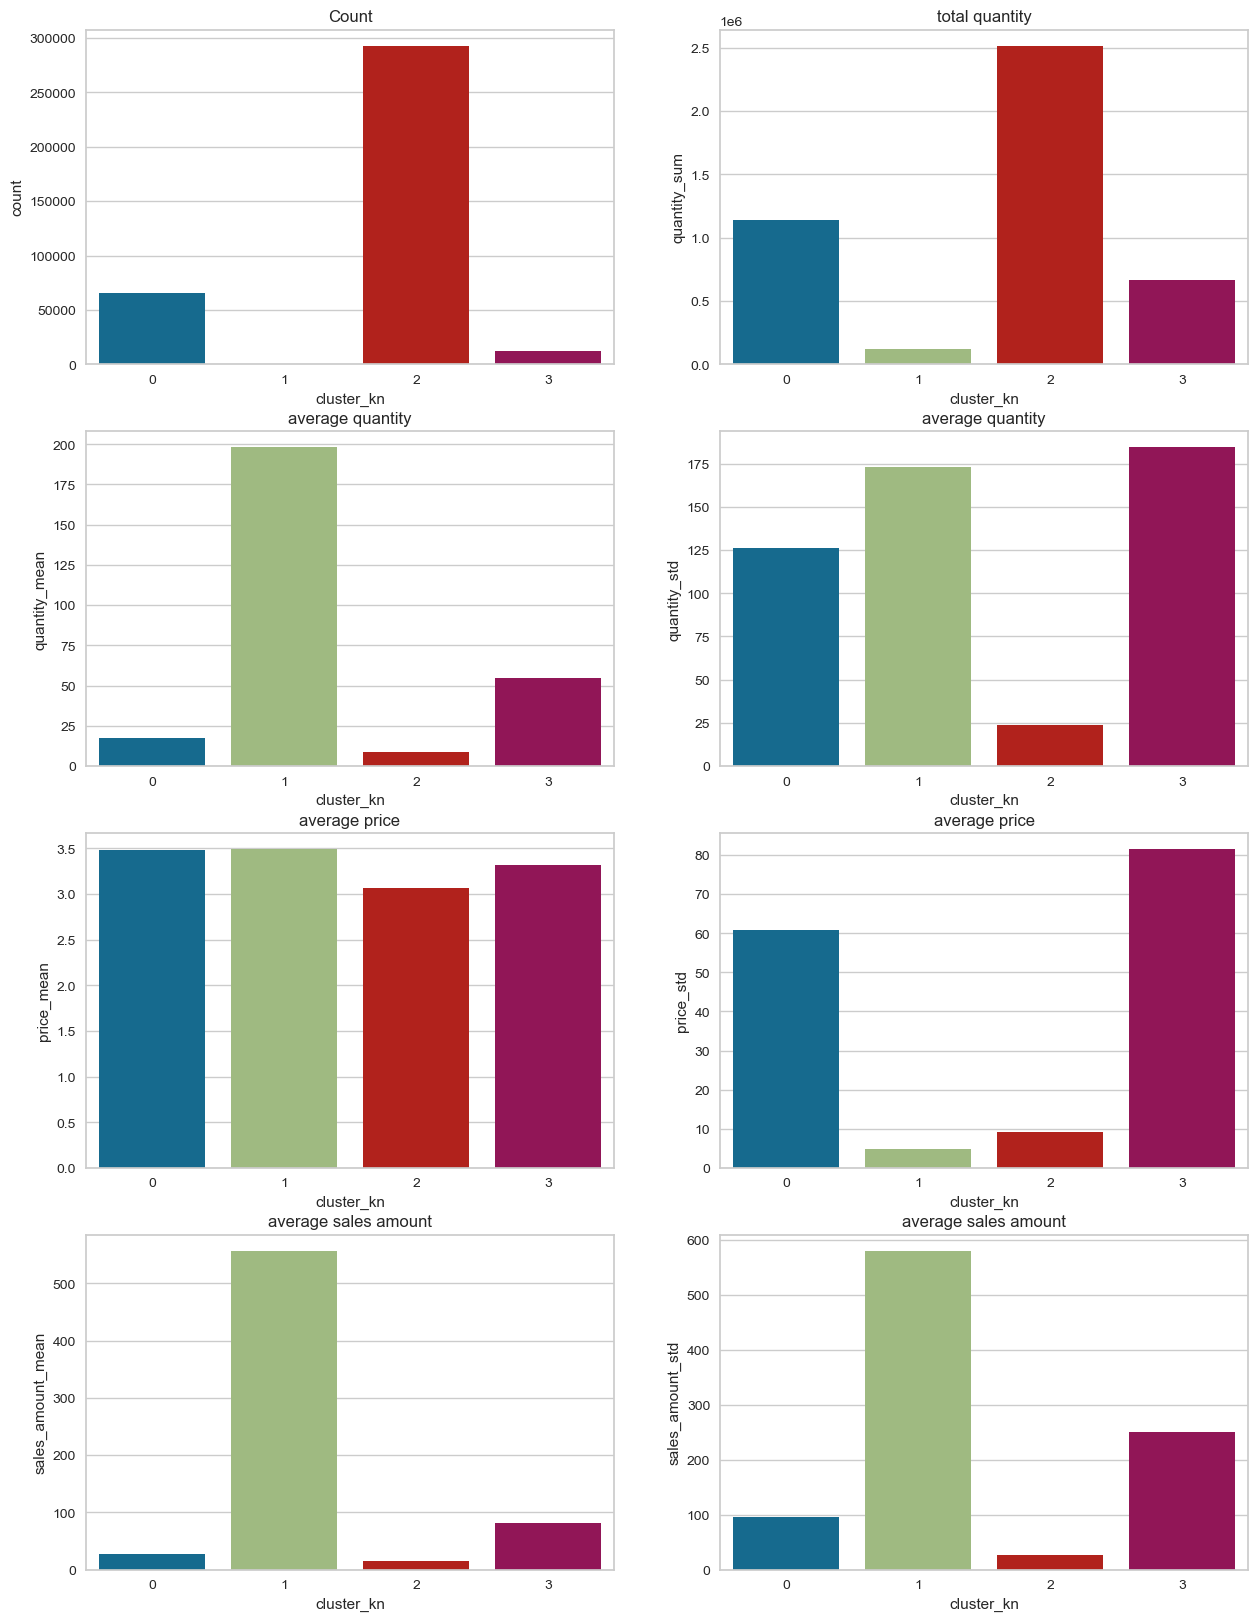

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
sns.barplot(x=cluster_stats.index, y='count', data=cluster_stats, ax=axes[0, 0])
axes[0, 0].set_title('Count')
sns.barplot(x=cluster_stats.index, y='quantity_sum', data=cluster_stats, ax=axes[0, 1])
axes[0, 1].set_title('total quantity')
sns.barplot(x=cluster_stats.index, y='quantity_mean', data=cluster_stats, ax=axes[1, 0])
axes[1, 0].set_title('average quantity')
sns.barplot(x=cluster_stats.index, y='quantity_std', data=cluster_stats, ax=axes[1, 1])
axes[1, 1].set_title('average quantity')
sns.barplot(x=cluster_stats.index, y='price_mean', data=cluster_stats, ax=axes[2, 0])
axes[2, 0].set_title('average price')
sns.barplot(x=cluster_stats.index, y='price_std', data=cluster_stats, ax=axes[2, 1])
axes[2, 1].set_title('average price')
sns.barplot(x=cluster_stats.index, y='sales_amount_mean', data=cluster_stats, ax=axes[3, 0])
axes[3, 0].set_title('average sales amount')
sns.barplot(x=cluster_stats.index, y='sales_amount_std', data=cluster_stats, ax=axes[3, 1])
axes[3, 1].set_title('average sales amount')

plt.subplots_adjust(hspace=0.2)

plt.show()

* 군집의 특성이 잘 나타나지 않음 ... RFM 지표의 기초통계량 확인해볼 필요 있음!

군집별 구매 추이 시각화

In [27]:
retail_sp.loc[:, 'InvoiceDate'] = retail_sp['InvoiceDate'].dt.date

c_quantity_by_date = retail_sp.groupby(['InvoiceDate', 'cluster_kn'])['Quantity'].sum().reset_index()
c_sales_amount_by_date = retail_sp.groupby(['InvoiceDate', 'cluster_kn'])['sales_amount'].sum().reset_index()

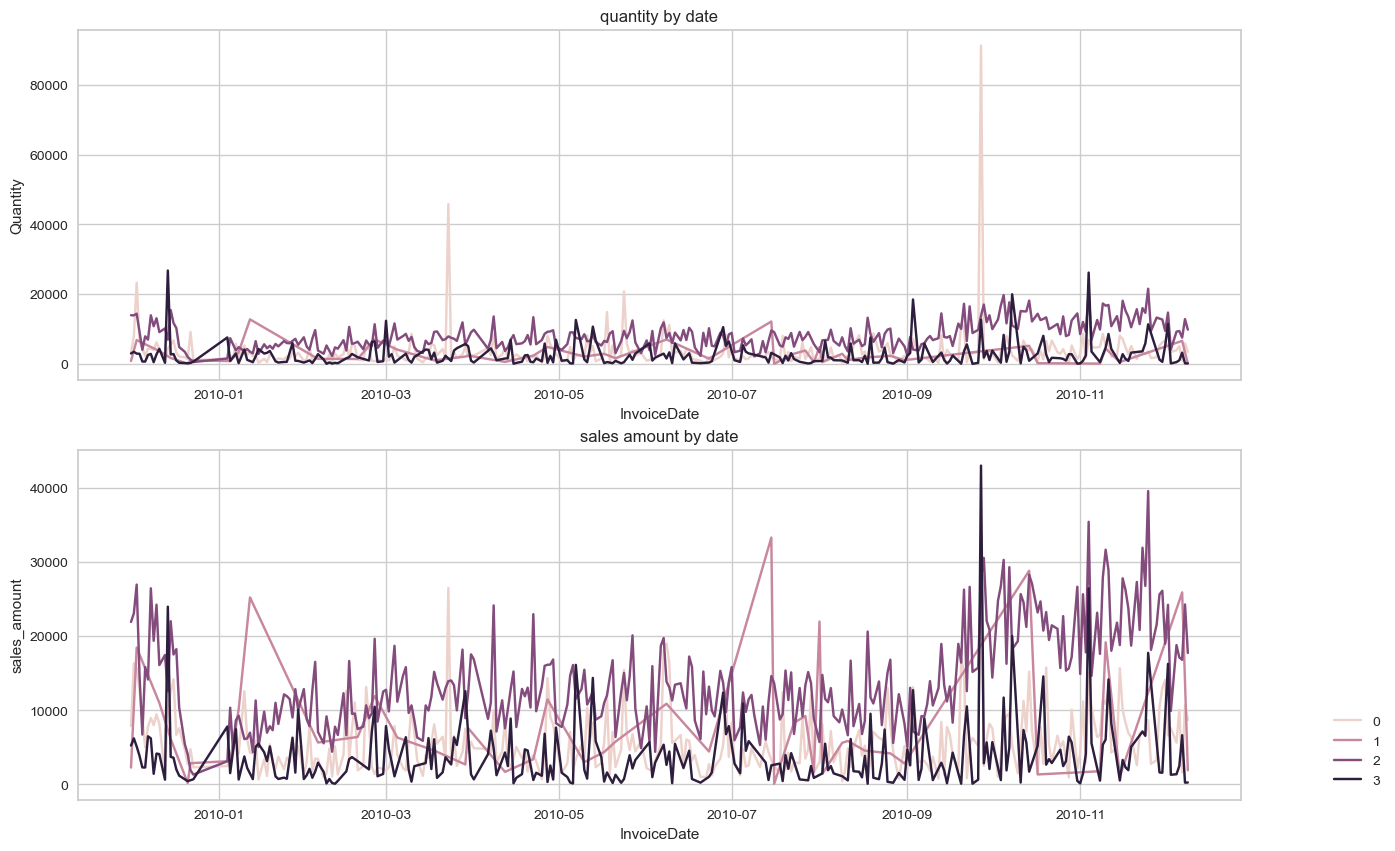

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(data=c_quantity_by_date, x='InvoiceDate', y='Quantity', hue='cluster_kn', ax=axes[0])
axes[0].set_title('quantity by date')
sns.lineplot(data=c_sales_amount_by_date, x='InvoiceDate', y='sales_amount', hue='cluster_kn', ax=axes[1])
axes[1].set_title('sales amount by date')

axes[0].legend().remove()
axes[1].legend(bbox_to_anchor=(1.1, 0), loc='lower center')

plt.show()

군집별 가장 자주 구매한 제품 추출

In [29]:
description = retail_sp.groupby('cluster_kn')['Description'].apply(
    lambda x: np.unique(x)[np.argmax(np.unique(x, return_counts=True)[1])]
)

pd.DataFrame(description)

,Description
cluster_kn,
0,WHITE HANGING HEART T-LIGHT HOLDER
1,BLACK HEART CARD HOLDER
2,WHITE HANGING HEART T-LIGHT HOLDER
3,WHITE HANGING HEART T-LIGHT HOLDER


* 대부분의 군집에서 white hanging heart t-light holder를 가장 자주 구매함: 상위 5개를 확인해보자!

In [30]:
cluster_product_counts = retail_sp.groupby('cluster_kn')['Description'].value_counts()
top5_products_by_cluster = cluster_product_counts.groupby(level=0).nlargest(5)

pd.DataFrame(top5_products_by_cluster)

count
cluster_kn cluster_kn Description                              
0          0          WHITE HANGING HEART T-LIGHT HOLDER    532
                      REGENCY CAKESTAND 3 TIER              301
                      STRAWBERRY CERAMIC TRINKET BOX        256
                      LUNCH BAG RED SPOTTY                  254
                      PACK OF 72 RETRO SPOT CAKE CASES      244
1          1          BLACK HEART CARD HOLDER                16
                      CREAM HEART CARD HOLDER                14
                      VINTAGE UNION JACK MEMOBOARD           11
                      WOOD BLACK BOARD ANT WHITE FINISH      10
                      HOME SWEET HOME MUG                     8
2          2          WHITE HANGING HEART T-LIGHT HOLDER   2372
                      REGENCY CAKESTAND 3 TIER             1156
                      ASSORTED COLOUR BIRD ORNAMENT        1055
                      STRAWBERRY CERAMIC TRINKET BOX       1028
                      REX CASH+CARRY JUMBO SHOPPER         1025
3          3          WHITE HANGING HEART T-LIGHT HOLDER    144
                      WOODEN FRAME ANTIQUE WHITE            140
                      WOODEN PICTURE FRAME WHITE FINISH     133
                      WOOD S/3 CABINET ANT WHITE FINISH     126
                      WOOD 2 DRAWER CABINET WHITE FINISH    123

4개의 군집 중 3개의 군집에서 white hanging heart t-light holder를 가장 자주 구매했지만, 
군집별 자주 구매한 제품 상위 5개를 출력해본 결과 각 군집에서의 구매행태가 유사하지는 않음

### 1.7 RFM 지표의 기초통계량 확인

In [31]:
cluster_agg = {'Frequency': ['count', 'mean', 'std'],
               'Monetary': ['mean', 'std'],
               'Recency': ['min', 'max', 'mean', 'std']
               }

rfm_stats = cust_rfm.groupby('cluster_kn').agg(cluster_agg)

rfm_stats

Frequency                               Monetary                \
               count        mean         std           mean           std   
cluster_kn                                                                  
0                135  482.770370  653.821726   13009.479430   6349.798143   
1                  1  627.000000         NaN  349164.350000           NaN   
2               3817   76.755567  100.642757    1134.119156   1272.394123   
3                 16  759.500000  752.153619   61273.691875  24068.562294   

           Recency                             
               min max        mean        std  
cluster_kn                                     
0             -311 -22  -49.851852  48.983171  
1              -22 -22  -22.000000        NaN  
2             -395 -22 -114.672256  97.666834  
3              -37 -22  -28.250000   4.328202

1번 군집은 count=1: clustering이 잘 되었는지 확인할 필요가 있어보임